In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import sys
import os 

os.chdir("../")

from einops import rearrange
import einops 
import numpy as np
import torch

from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from typing import List
from torchvision.transforms import Compose, ToTensor, Lambda
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib notebook

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset

In [3]:
dataset = load_dataset("nielsr/CelebA-faces")

CHANNELS = 3
BATCH_SIZE = 35
TIMESTEPS = 1000
UPSCALE_IMAGE_SIZE = 128

_dataset_transform = transforms.Compose(
    [   
        transforms.Resize((UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.25, hue=0.05, contrast=0.05, saturation=0.05),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        transforms.RandomAffine(degrees=(0, 0), translate=(0., 0.0), scale=(0.9, 1.2)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)

def normalize(examples):
    
    examples["x"] = [_dataset_transform(image) for image in examples["image"]]
    del examples["image"]

    return examples

transformed_dataset = dataset.with_transform(normalize)

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=BATCH_SIZE, shuffle=True)

reverse_transform = transforms.Compose([
     transforms.Lambda(lambda t: torch.clip(t, -1, 1)),
     transforms.Lambda(lambda t: (t + 1) / 2),
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.to("cpu"),),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
])

Using custom data configuration nielsr--CelebA-faces-ffaff57f221b8a22
Found cached dataset parquet (/home/johannes/.cache/huggingface/datasets/nielsr___parquet/nielsr--CelebA-faces-ffaff57f221b8a22/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

# Diffusion process

In [2]:
from diffusion import Diffusion

def generate_backward_process(
    model: torch.nn.Module,
    diffusion: Diffusion,
    timesteps: int,
    shape: List[int],
    device: str,
    x: torch.Tensor = None,
):
    
    klass = torch.Tensor([klass]).to(device)
    
    model.eval()
    
    with torch.no_grad():

        x = torch.randn(shape, device=device) if x is None else x
        timesteps_iter = list(range(timesteps))
        timesteps_iter.reverse()
        
        Y = [x]
        
        for t in timesteps_iter:

            t = torch.Tensor([t]).long().to(device)

            predicted_noise = model.forward(
                x,
                t,
            )
            
            x = diffusion.backward(x, predicted_noise, t)
            
            Y.append(x)
            
        return torch.cat(Y, dim=0)

def diffusion_process(
    x: torch.Tensor,
    diffusion: Diffusion,
):
    
    assert len(x.shape) == 3
    
    X = []
    N = []

    for timestep in range(diffusion._timesteps):

        t = torch.Tensor([timestep]).long()

        x_noised, noise, _ = diffusion.forward(
            x=x,
            t=t,
        )

        X.append(x_noised.to("cpu"))
        N.append(noise.to("cpu"))

        
    return X, N

<IPython.core.display.Javascript object>


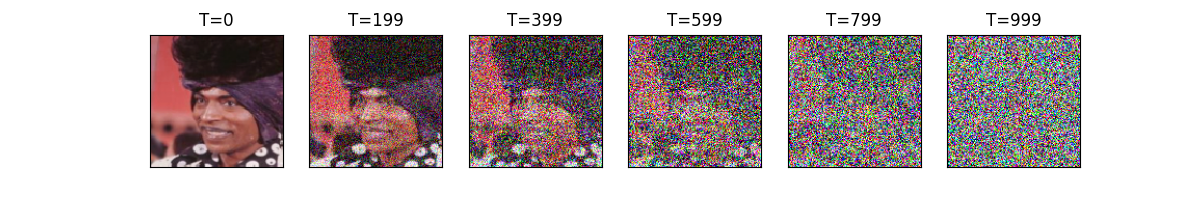

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib notebook

batch = next(iter(dataloader))

diffusion_linear = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
)

Xlinear, Nlinear = diffusion_process(
    x=batch["x"][0, :, :, :],
    diffusion=diffusion_linear,
)

DISPLAY_NIMAGES = 6

indicies = np.linspace(0, len(Xcosin) -1 , DISPLAY_NIMAGES, dtype=int)

fig, axs = plt.subplots(1, DISPLAY_NIMAGES, figsize=(12, 2))

for i, process_i in enumerate(indicies):
    
    x = reverse_transform(Xcosin[process_i])
    y = reverse_transform(Xlinear[process_i])

    axs[i].imshow(x)
    axs[i].set_title(f"T={process_i}")
    
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)

<IPython.core.display.Javascript object>


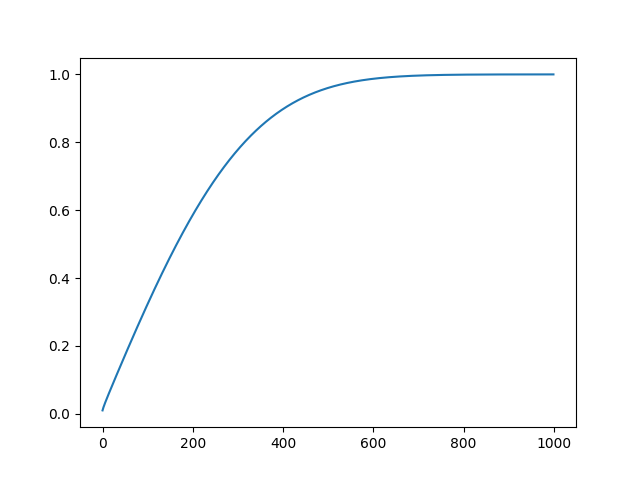

In [6]:
diffusion_cosin = Diffusion(
    timesteps=1000,
    schedular="linear",
)

plt.plot(diffusion_cosin._sqrt_one_minus_alphas_cumprod.numpy())

# Train..

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from unet import Unet

In [ ]:
diffusion = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
    start=0.0001,
    end=0.01,
)

model = Unet(
    channels=[64, 256, 256, 512, 1024],
    attention_channels=[512, 1024],
    in_channels=CHANNELS,
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

iteration = 0
image_saves = 0

EXPERIMENT_NAME = "celeba_v2_xl"
ACCUMULATION_RUNS = 1

_ = model.to(device)

writer = SummaryWriter(f"runs/{EXPERIMENT_NAME}")

In [5]:
# Load a previous checkpoint
model.load(folder=f"ckp/{EXPERIMENT_NAME}", name="best.ckp")

In [6]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
total_params = sum([np.prod(p.size()) for p in model_parameters])
total_params

127507395

## Traing loop

In [ ]:
model.to(device)

for e in range(100):

    for step, batch in enumerate(dataloader):

        iteration += 1
        
        x = batch["x"].to(device)
        
        x_noised, noise, time = diffusion.forward(x)
        
        noise_predicted = model.forward(
            x=x_noised.to(device),
            time=time.to(device),
        )

        loss = diffusion.loss(noise, noise_predicted) 
        loss_scaled = loss / ACCUMULATION_RUNS
        
        loss_scaled.backward()
        
        if iteration % ACCUMULATION_RUNS == 0:
            
            optimizer.step()
            model.zero_grad()
        
        writer.add_scalar("loss", loss, iteration)
        
        if iteration % 500 == 0:
            
            y = generate_backward_process(
                model=model,
                diffusion=diffusion,
                timesteps=TIMESTEPS,
                shape=[1, CHANNELS, UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE],
                device=device,
            )
        
            writer.add_image(
                f'images',
                np.asarray(reverse_transform(y[-1, :, :, :])),
                image_saves,
                dataformats='HWC'
            )
            
            image_saves += 1
            
            model.save(folder=f"ckp/{EXPERIMENT_NAME}", name="latest.ckp")
 
    print("epoch", e)

# Inference

In [9]:
from unet import Unet
from PIL import Image

In [4]:
diffusion = Diffusion(
    timesteps=TIMESTEPS,
    schedular="linear",
)

model = Unet(
    channels=[64, 256, 512, 1024],
    in_channels=CHANNELS,
    attention_channels=[64, 256, 512, 1024],
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
)

model.load(folder="ckp/celeba_v2_large", name="best.ckp")

_ = model.to("cuda")

## Denoise noised image, select witch timestep, i.e. how much noise to add..

In [51]:
batch = next(iter(dataloader))
xx = batch["x"].to(device)[0, :, :, :].unsqueeze(0)

timestep = 200

x_noised, noise, time = diffusion.forward(xx, torch.Tensor([timestep]).long().to(device))

with torch.no_grad():

    timesteps_iter = list(np.linspace(0, timestep,  timestep + 1))
    timesteps_iter.reverse()

    Y = [x_noised[0, :, :, :]]

    for t in timesteps_iter:

        t = torch.Tensor([t]).long().to(device)

        predicted_noise = model.forward(
            x_noised,
            t,
        )

        x_noised = diffusion.backward(x_noised, predicted_noise, t)

        Y.append(x_noised[0, :, :, :])
        
Y = torch.stack(Y)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(reverse_transform(xx[0, :, :, :]))
axs[0].set_title("Original Image")
axs[1].imshow(reverse_transform(Y[0, :, :, :]))
axs[1].set_title("Original Image + Noise")
axs[2].imshow(reverse_transform(Y[timestep, :, :, :]))
axs[2].set_title("Denoised Image")

for i in range(3):
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)

## Generate images


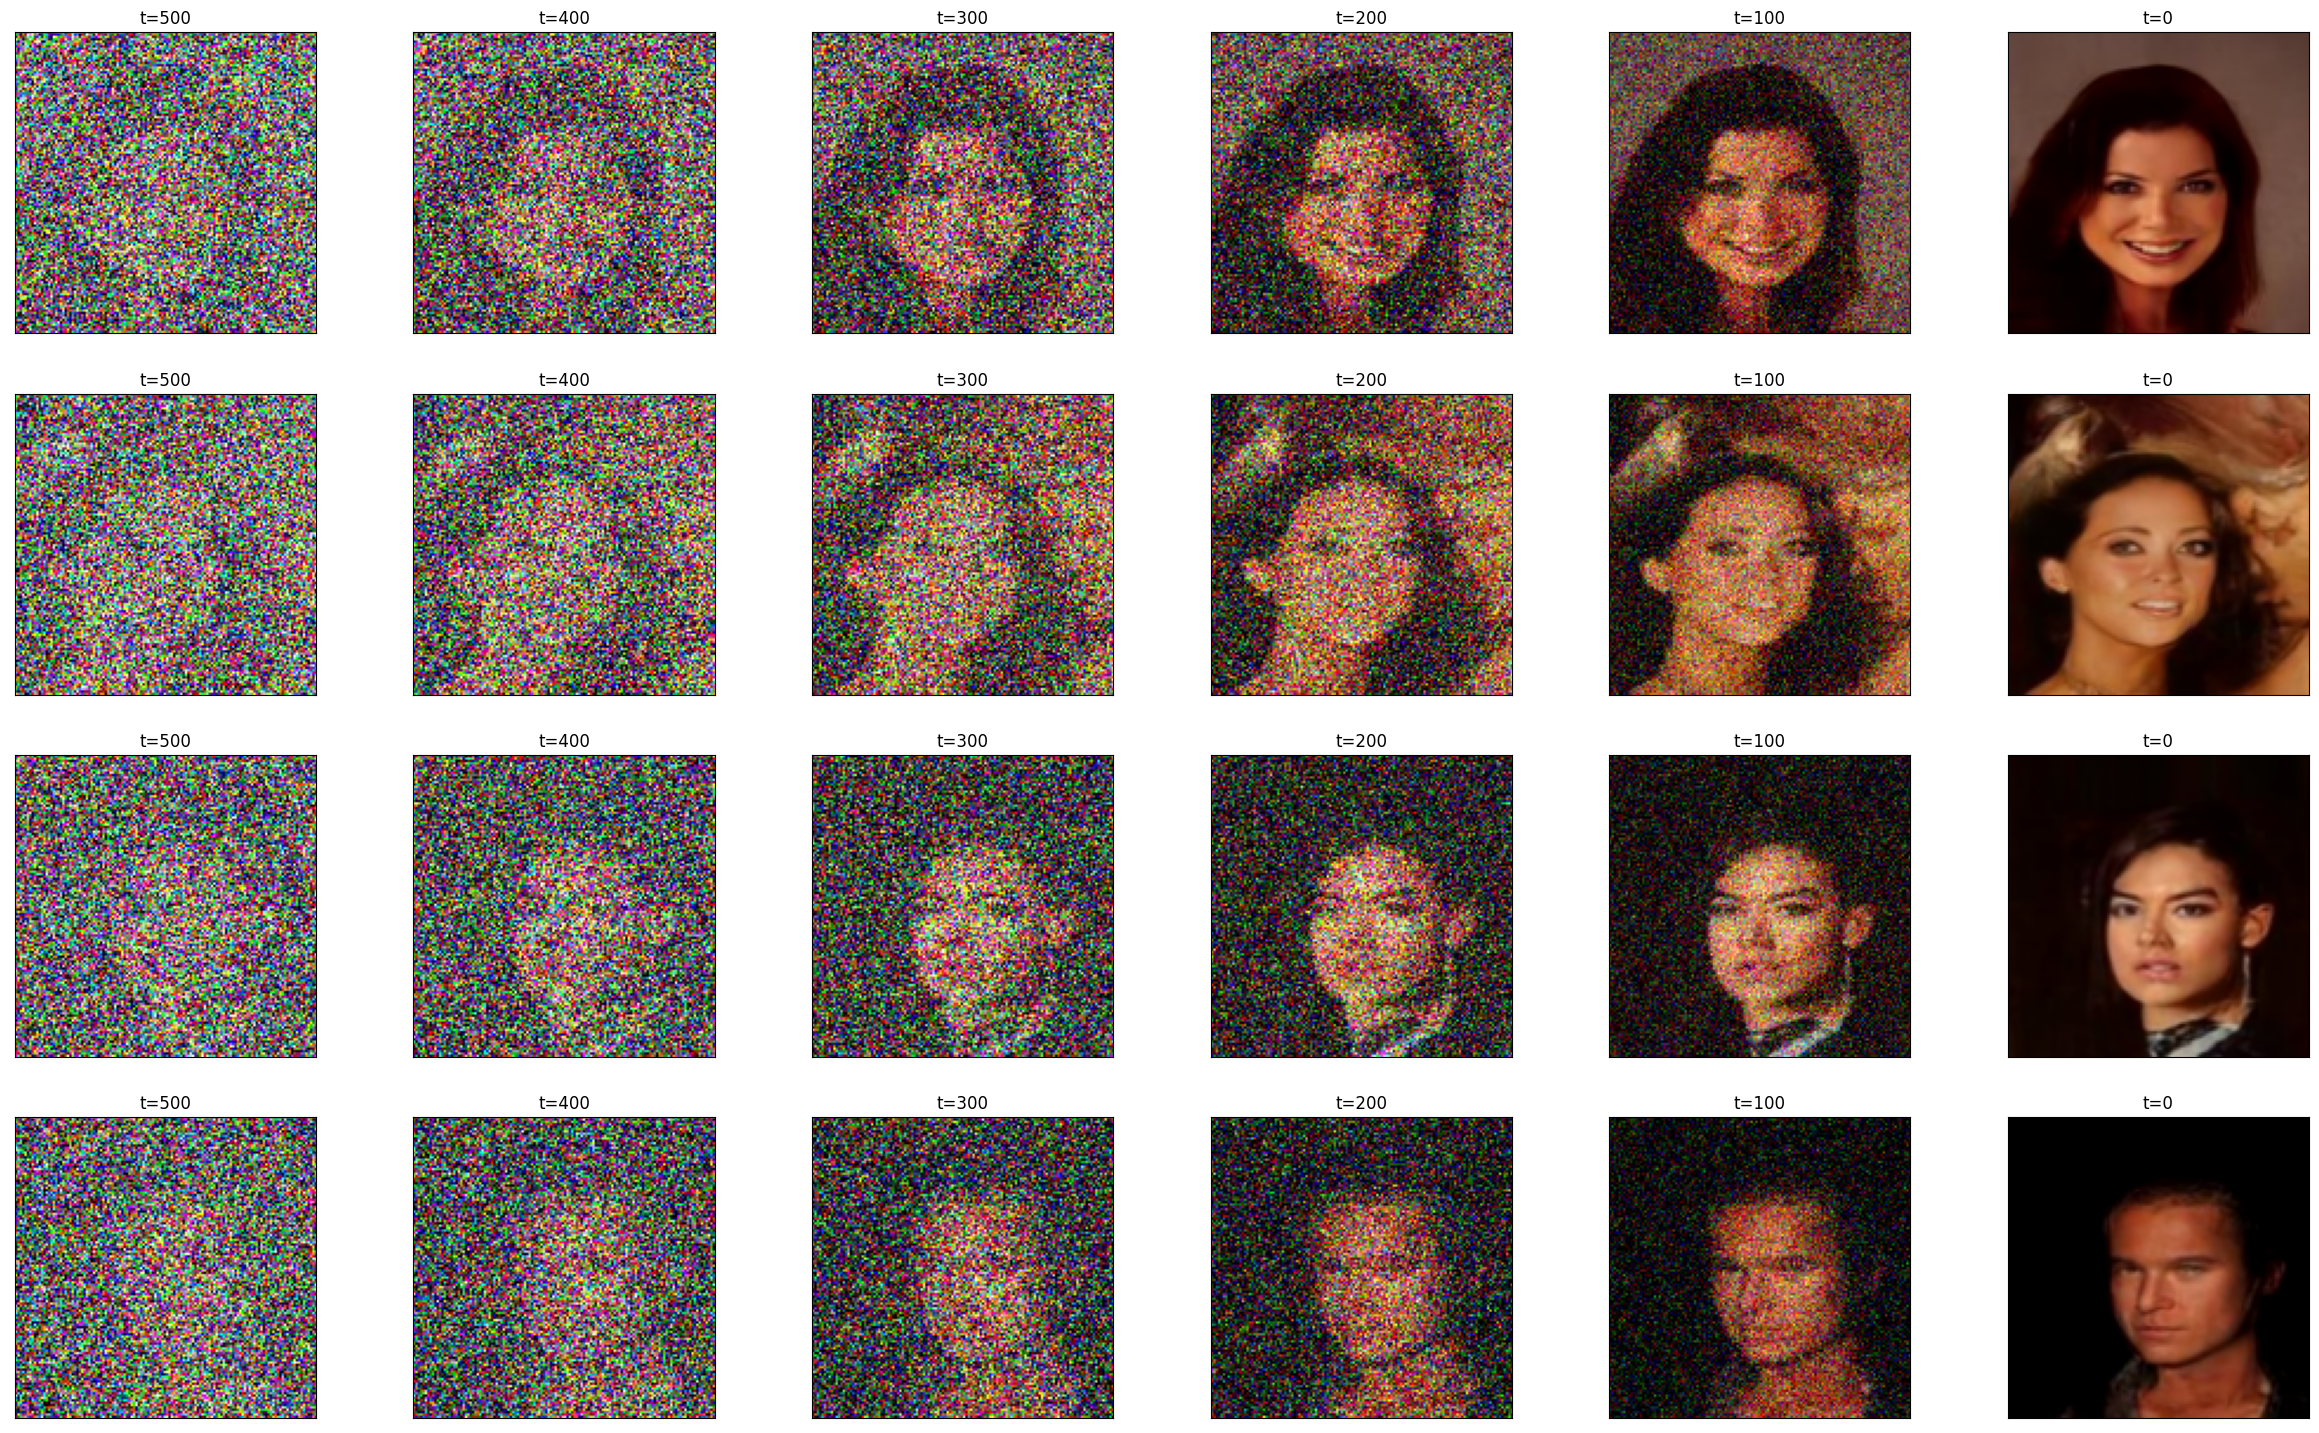

In [53]:
indicies = np.linspace(500, TIMESTEPS , 6, dtype=int)
N_ROWS = 4
fig, axs = plt.subplots(N_ROWS, len(indicies), figsize=(30, 18))

for i in range(N_ROWS):
    
    Y = generate_backward_process(
        model=model,
        diffusion=diffusion,
        timesteps=TIMESTEPS,
        shape=[1, CHANNELS, UPSCALE_IMAGE_SIZE, UPSCALE_IMAGE_SIZE],
        device=device,
    )

    for ii, process_i in enumerate(indicies):
        y = reverse_transform(Y[process_i, :, :, :])
        axs[i][ii].imshow(y)
        axs[i][ii].set_title(f"t={Y.shape[0] -1- process_i}")
        axs[i][ii].axes.get_xaxis().set_visible(False)
        axs[i][ii].axes.get_yaxis().set_visible(False)